## Training continuous embeddings 
We use the generated samples to train embeddings using word2vec.

In [120]:
import os
import numpy as np
import pandas as pd
import json
import lightgbm as lgb
from collections import Counter
import matplotlib.pyplot as plt
from scipy import interp
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc, f1_score, recall_score, precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import balanced_accuracy_score as bacc
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from gensim.models import Word2Vec
from sklearn.model_selection import KFold

In [182]:
graphnames = ['Cora', 'Citeseer', 'Pubmed', 'HomoSapiens', 'BlogCatalog', 'Wikipedia']
idx = 1
graphname = graphnames[idx]
multilabel=False
if idx > 2:
    multilabel=True
emb_size = 10
hop = 4
data_dir = os.path.expanduser("../Graphs/"+graphname)
print(data_dir)

../Graphs/Citeseer


In [183]:
trained_embsize = 50

In [184]:
rwalk_path = data_dir + "/vectors/vectors_rwalk_all_" + str(emb_size) + "_hop_" + str(hop) + ".json"
with open(rwalk_path, "r") as read_file:
    rwalk_vectors = json.load(read_file)

In [185]:
nodesketch_path = data_dir + "/vectors/vectors_nodesketch_all_" + str(emb_size) + "_hop_" + str(hop) + ".json"
with open(nodesketch_path, "r") as read_file:
    ns_vectors = json.load(read_file)

In [186]:
minwise_path = data_dir + "/vectors/vectors_minwise_all_" + str(emb_size) + "_hop_" + str(hop) + ".json"
with open(minwise_path, "r") as read_file:
    minwise_vectors = json.load(read_file)

In [187]:
key = list(minwise_vectors.keys())[10]

In [188]:
rwalk_vectors[key]

[['fiebig97raw', 'label=IR', 'w-2641'],
 ['458208', 'label=Agents', 'w-140'],
 ['nodine99active', 'label=DB', 'w-603'],
 ['540501', 'label=Agents', 'w-591'],
 ['455961', 'label=IR', 'w-1790'],
 ['nodine98overview', 'label=DB', 'w-370'],
 ['540501', 'label=Agents', 'w-532'],
 ['nodine99active', 'label=DB', 'w-643'],
 ['100157', 'label=Agents', 'w-3447'],
 ['nodine98overview', 'label=DB', 'w-56']]

In [189]:
minwise_vectors[key]

[['appiani00multiagent', 'label=Agents', 'w-2567'],
 ['decker95coordination', 'label=Agents', 'w-1764'],
 ['marini00specification', 'label=Agents', 'w-1564'],
 ['donini98allog', 'label=DB', 'w-974'],
 ['dix00impact', 'label=DB', 'w-37'],
 ['28315', 'label=DB', 'w-3207'],
 ['455961', 'label=IR', 'w-1168'],
 ['martelli99logic', 'label=Agents', 'w-2391'],
 ['carro99concurrency', 'label=AI', 'w-1104'],
 ['hunter00merging', 'label=DB', 'w-2236']]

In [190]:
l1_path = data_dir + "/vectors/vectors_l1_all_" + str(emb_size) + "_hop_" + str(hop) + ".json"
with open(l1_path, "r") as read_file:
    l1_vectors = json.load(read_file)

In [191]:
l2_path = data_dir + "/vectors/vectors_l2_all_" + str(emb_size) + "_hop_" + str(hop) + ".json"
with open(l2_path, "r") as read_file:
    l2_vectors = json.load(read_file)

In [192]:
def get_pairs(vectors):
    pairs = []
    cnt = 0
    for node, features in vectors.items():
        for feature in features:
            pairs.append([node, feature[0]])
    return pairs

In [193]:
rwalk_pairs = get_pairs(rwalk_vectors)

In [194]:
ns_pairs = get_pairs(ns_vectors)

In [195]:
minwise_pairs = get_pairs(minwise_vectors)

In [196]:
l1_pairs = get_pairs(l1_vectors)

In [197]:
l2_pairs = get_pairs(l2_vectors)

In [198]:
len(rwalk_pairs), len(ns_pairs), len(minwise_pairs), len(l1_pairs), len(l2_pairs)

(33120, 33120, 33120, 33120, 33120)

In [199]:
print(rwalk_pairs[:10])

[['100157', 'joseph01why'], ['100157', '506507'], ['100157', 'martelli99specification'], ['100157', '100157'], ['100157', 'wache01ontologybased'], ['100157', 'dix01metaagent'], ['100157', 'padgett98simple'], ['100157', '100157'], ['100157', 'gray99finding'], ['100157', '385259']]


In [200]:
model_rwalk_path = data_dir + '/w2v/w2v_rwalk_emb_'+str(emb_size)+'_hop_' + str(hop) + \
                '_dim_' + str(trained_embsize) +'.model'
model_rwalk_exists = os.path.exists(model_rwalk_path)
print(model_rwalk_exists)

True


In [201]:
if model_rwalk_exists:
    model_rwalk = Word2Vec.load(model_rwalk_path)
else:
    model_rwalk = Word2Vec(
                rwalk_pairs, 
                size=trained_embsize, 
                window=2, 
                min_count=0, 
                sg=1, 
                workers=4, 
                iter=300)

In [202]:
if not model_rwalk_exists:
    model_rwalk.save(model_rwalk_path)

In [203]:
model_ns_path = data_dir + '/w2v/w2v_ns_emb_'+str(emb_size)+'_hop_' + str(hop) + \
        '_dim_' + str(trained_embsize) +'.model'
model_ns_exists = os.path.exists(model_ns_path)
print(model_ns_exists)

True


In [204]:
if model_ns_exists:
    model_ns = Word2Vec.load(model_ns_path)
else:
    model_ns = Word2Vec(
                ns_pairs, 
                size=trained_embsize, 
                window=2, 
                min_count=0, 
                sg=1, 
                workers=4, 
                iter=300)
    model_ns.save(model_ns_path)

In [205]:
model_minwise_path = data_dir + '/w2v/w2v_minwise_emb_'+str(emb_size)+'_hop_' + str(hop) + \
        '_dim_' + str(trained_embsize) +'.model'
model_minwise_exists = os.path.exists(model_minwise_path)
print(model_minwise_exists)

True


In [206]:
if model_minwise_exists:
    model_minwise = Word2Vec.load(model_minwise_path)
else:
    model_minwise = Word2Vec(
                minwise_pairs, 
                size=trained_embsize, 
                window=2, 
                min_count=0, 
                sg=1, 
                workers=4, 
                iter=300)
    model_minwise.save(model_minwise_path)

In [207]:
model_l1_path = data_dir + '/w2v/w2v_l1_emb_'+str(emb_size)+'_hop_' + str(hop) + \
        '_dim_' + str(trained_embsize) +'.model'
model_l1_exists = os.path.exists(model_l1_path)
print(model_l1_exists)

True


In [208]:
if model_l1_exists:
    model_l1 = Word2Vec.load(model_l1_path)
else:
    model_l1 = Word2Vec(
                l1_pairs, 
                size=trained_embsize, 
                window=2, 
                min_count=0, 
                sg=1, 
                workers=4, 
                #negative=2,
                iter=300)
    model_l1.save(model_l1_path)

In [209]:
model_l2_path = data_dir + '/w2v/w2v_l2_emb_'+str(emb_size)+'_hop_' + str(hop) + \
        '_dim_' + str(trained_embsize) +'.model'
model_l2_exists = os.path.exists(model_l2_path)
print(model_l2_exists)

True


In [210]:
if model_l2_exists:
    model_l2 = Word2Vec.load(model_l2_path)
else:
    model_l2 = Word2Vec(
                l2_pairs, 
                size=trained_embsize, 
                window=2, 
                min_count=0, 
                sg=1, 
                workers=4, 
                #negative=2,
                iter=300)
    model_l2.save(model_l2_path)

In [211]:
nodes_with_labels = pd.read_csv(data_dir + '/data/nodes_with_labels.csv')

In [212]:
nodes_with_labels.head()

,node,label
0,100157,Agents
1,100598,IR
2,105684,Agents
3,11099,DB
4,114091,AI


In [213]:
# generate a dataset with labels from the trained embeddings
def get_X_y(model, nodes_with_labels, multilabel=False):
    
    X = []
    y = []
    labels = {}
    for idx, row in nodes_with_labels.iterrows():
        
        X.append([float(x) for x in model[str(row['node'])]])
        row_labels = [row['label']]
        if multilabel:
            row_labels = row["label"].split("=")
            row_labels = row_labels[1:-1]   
        for rl in row_labels:
            if rl not in labels:
                labels[rl] = len(labels)
        enc_label = []
        for rl in row_labels:
            enc_label.append(labels[rl])
        y.append(enc_label)
    X = np.array(X)
    return X, y

In [214]:
X_rw, y_rw = get_X_y(model_rwalk, nodes_with_labels, multilabel=multilabel)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [215]:
X_ns, y_ns = get_X_y(model_ns, nodes_with_labels, multilabel=multilabel)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [216]:
X_mw, y_mw = get_X_y(model_minwise, nodes_with_labels, multilabel=multilabel)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [217]:
X_l1, y_l1 = get_X_y(model_l1, nodes_with_labels, multilabel=multilabel)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [218]:
X_l2, y_l2 = get_X_y(model_l2, nodes_with_labels, multilabel=multilabel)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [219]:
X_rw.shape, X_ns.shape, X_mw.shape, X_l1.shape, X_l2.shape

((3312, 50), (3312, 50), (3312, 50), (3312, 50), (3312, 50))

In [220]:
y_l1[:5]

[[0], [1], [0], [2], [3]]

In [221]:
def plot_label_distribution(y):
    counts = {}
    for labels_i in y:
        for l_i in labels_i:
            counts.setdefault(l_i, 0)
            counts[l_i] += 1
    
    top_counts = sorted([(cnt, lbl) for lbl, cnt in counts.items()], reverse=True)
    plt.bar([i for i in range(len(top_counts))], [c for c, _ in top_counts], alpha=0.7)

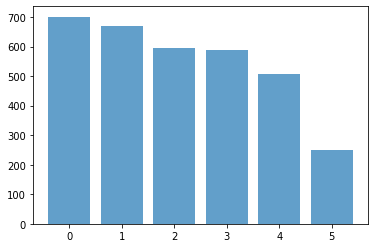

In [222]:
plot_label_distribution(y_ns)

In [223]:
def one_hot(y, top=10):
    
    counts = {}
    for labels_i in y:
        for l_i in labels_i:
            counts.setdefault(l_i, 0)
            counts[l_i] += 1
    
    top_counts = sorted([(cnt, lbl) for lbl, cnt in counts.items()], reverse=True)[:top]
    labels = {cnt_lbl[1]: i for i,cnt_lbl in enumerate(top_counts)}
    
    top = min(top, len(counts)-1)
    
#     labels = {}
#     for labels_i in y:
#         for l_i in labels_i:
#             labels.setdefault(l_i, len(labels))
    encoded = np.zeros((len(y), top+1))
    for i, labels_i in enumerate(y):
        for l_i in labels_i:
            if l_i in labels:
                encoded[i, labels[l_i]] = 1
            else:
                encoded[i, top] = 1
            
    return encoded
    

In [224]:
one_hot(y_rw, top=10).shape

(3312, 6)

In [225]:
def plot_roc(X, y, nr_iters):
    labels = set()
    for labels_i in y:
        for l_i in labels_i:
            labels.add(l_i)
    lgb_params = {'objective':'multiclass',
                  'metric': 'multi_logloss',
            'boosting_type':'gbdt',
            'n_jobs':4,
            'max_depth':-1,
             'num_class': len(labels),
            'learning_rate':0.1,
            'tree_learner':'serial',
            'n_estimators':2000,
            'verbose':-1,
            'seed': 73,
            'feature_fraction':1}
    micros = []
    macros = []
    for i in range(nr_iters):
        print('Iter', i)
        y = MultiLabelBinarizer().fit_transform(y)
        X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8)
        clf = lgb.LGBMClassifier( **lgb_params) 
        clf = OneVsRestClassifier(clf)
        X_train_clf, X_test, y_train_clf, y_test =  train_test_split(X_train, y_train)
        
        clf.fit(X_train_clf, y_train_clf)#, eval_set=[(X_train_clf, y_train_clf), (X_test, y_test)], 
                        # early_stopping_rounds=50, verbose=100)
        y_pred_prob = clf.predict_proba(X_val)
        y_val_mat = one_hot(y_val)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        n_classes = y_val_mat.shape[1]
        y_test_mat = one_hot(y_test)

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_val_mat[:, i], y_pred_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        fpr["micro"], tpr["micro"], _ = roc_curve(y_val_mat.ravel(), y_pred_prob.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        print('Micro AUC', roc_auc["micro"])
        print('Macro AUC', roc_auc["macro"])
        micros.append(roc_auc["micro"])
        macros.append(roc_auc["macro"])
    mean_micro = 100.0*np.round(np.mean(micros), 3)
    mean_macro = 100.0*np.round(np.mean(macros), 3)
    std_micro = 100.0*np.round(np.std(micros), 3)
    std_macro = 100.0*np.round(np.std(macros), 3)
    print("{} $\pm$ {} & {} $\pm$ {}".format(np.round(mean_micro, 3), np.round(std_micro, 3),\
                                             np.round(mean_macro, 3), np.round(std_macro, 3)))
    
    
#     # Plot all ROC curves
#     plt.figure()
#     plt.plot(fpr["micro"], tpr["micro"],
#              label='micro-average ROC curve (area = {0:0.3f})'
#                    ''.format(roc_auc["micro"]),
#              color='deeppink', linestyle=':', linewidth=4)

#     plt.plot(fpr["macro"], tpr["macro"],
#              label='macro-average ROC curve (area = {0:0.3f})'
#                    ''.format(roc_auc["macro"]),
#              color='navy', linestyle=':', linewidth=4)
    
# #     plt.figure()
#     lw = 2
# #     plt.plot(fpr[2], tpr[2], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
#     plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic example')
#     plt.legend(loc="lower right")
#     plt.show()

In [226]:
def multilabel_classification(X, y, top_classes, res_path):
    # mlb = MultiLabelBinarizer()
    y = one_hot(y, top_classes) # mlb.fit_transform(y)
    
    f1s = []
    nr_iters = 10
    #for train_index, test_index in kf.split(X):
    for i in range(nr_iters):    
        print('Iter', i)
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)
        # X_train, X_test = X[train_index], X[test_index]
        # y_train, y_test = y[train_index], y[test_index]
        model = LogisticRegression(C=1.0, penalty='l1', dual=False, solver='liblinear')
        model = OneVsRestClassifier(model)
        model.fit(X_train, y_train)

        # n_classes = y_test.shape[1]
        y_pred = model.predict_proba(X_test)
        y_pred_abs = model.predict(X_test)
        
        f1 = f1_score(y_test, y_pred_abs, average='micro')
        print(f1)
        f1s.append(f1)
        
        print("prec", precision_score(y_test.ravel(), y_pred_abs.ravel()))
        print("recall", recall_score(y_test.ravel(), y_pred_abs.ravel()))
        f1 = f1_score(y_test.ravel(), y_pred_abs.ravel(), average='binary')
        print("F1", f1)

#         fpr = dict()
#         tpr = dict()
#         roc_auc = dict()

#         for i in range(n_classes):
#             fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
#             roc_auc[i] = auc(fpr[i], tpr[i])

#         fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
#         roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#         # First aggregate all false positive rates
#         all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#         # Then interpolate all ROC curves at this points
#         mean_tpr = np.zeros_like(all_fpr)
#         for i in range(n_classes):
#             mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

#         # Finally average it and compute AUC
#         mean_tpr /= n_classes

#         fpr["macro"] = all_fpr
#         tpr["macro"] = mean_tpr
#         roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
#         micros.append(roc_auc["micro"])
#         macros.append(roc_auc["macro"])
        
    print('Micro F1', np.mean(f1s))
#     print('Macro AUC', np.mean(macros))
#     print('Accuracy', np.mean(accs))
    
#     with open(res_path + "_w2v_accuracy.txt", "w") as f:
#         f.write(str(np.mean(accs)) + " " + str(np.std(accs)))
#     with open(res_path + "_w2v_micro_F1.txt", "w") as f:
#         f.write(str(np.mean(f1s)) + " " + str(np.std(f1s)))

In [227]:
X_rw

array([[-0.2377793 ,  0.2348129 ,  1.64202166, ..., -1.96658158,
         0.65738982, -0.1094127 ],
       [ 0.39379716, -0.61176097,  0.04141475, ...,  0.94576615,
         0.41367307,  1.86874604],
       [ 0.05979461,  0.63366288,  0.19363481, ...,  0.51234955,
         0.66376966,  0.71985   ],
       ...,
       [-0.22904207, -0.39310053,  0.11675517, ..., -0.73740858,
         0.52258742,  1.51541424],
       [-0.22558014,  0.45726946, -0.35015565, ...,  0.22818127,
         0.59049648,  0.33673689],
       [-0.71556801, -0.45588899, -0.24389426, ...,  0.18431491,
         0.6391626 ,  1.21205676]])

In [228]:
top_classes = 30

In [229]:
res_path = data_dir + "/results/rwalk_" + str(emb_size) + "_hop_" + str(hop) 
multilabel_classification(X_rw, y_rw, top_classes=top_classes, res_path=res_path)

Iter 0
0.43514997887621465
prec 0.7243319268635724
recall 0.3109903381642512
F1 0.43514997887621465
Iter 1
0.43314822725331054
prec 0.7401459854014598
recall 0.3061594202898551
F1 0.43314822725331054
Iter 2
0.42225998300764656
prec 0.7120343839541547
recall 0.3001207729468599
F1 0.42225998300764656
Iter 3
0.42580101180438445
prec 0.7053072625698324
recall 0.30495169082125606
F1 0.42580101180438445
Iter 4
0.43996641477749787
prec 0.721763085399449
recall 0.3164251207729469
F1 0.43996641477749787
Iter 5
0.43834459459459457
prec 0.7289325842696629
recall 0.3134057971014493
F1 0.43834459459459457
Iter 6
0.427061310782241
prec 0.7122708039492243
recall 0.30495169082125606
F1 0.427061310782241
Iter 7
0.4392090870845604
prec 0.723994452149792
recall 0.31521739130434784
F1 0.4392090870845604
Iter 8
0.4242928452579035
prec 0.6818181818181818
recall 0.3079710144927536
F1 0.4242928452579035
Iter 9
0.42337662337662335
prec 0.7477064220183486
recall 0.29528985507246375
F1 0.42337662337662335
Micro 

In [230]:
res_path = data_dir + "/results/nodesketch_" + str(emb_size) + "_hop_" + str(hop) 
multilabel_classification(X_ns, y_ns, top_classes=top_classes, res_path=res_path)

Iter 0
0.4879398971925662
prec 0.7067583046964491
recall 0.3725845410628019
F1 0.4879398971925662
Iter 1
0.46858532630725586
prec 0.7127003699136868
recall 0.34903381642512077
F1 0.46858532630725586
Iter 2
0.45810055865921784
prec 0.6752941176470588
recall 0.3466183574879227
F1 0.45810055865921784
Iter 3
0.47473560517038776
prec 0.6755852842809364
recall 0.36594202898550726
F1 0.47473560517038776
Iter 4
0.48646496815286616
prec 0.7137850467289719
recall 0.3689613526570048
F1 0.48646496815286616
Iter 5
0.4800974817221771
prec 0.7332506203473945
recall 0.35688405797101447
F1 0.4800974817221771
Iter 6
0.47967806841046284
prec 0.7189384800965019
recall 0.35990338164251207
F1 0.47967806841046284
Iter 7
0.47512932749701553
prec 0.6966161026837806
recall 0.3605072463768116
F1 0.47512932749701553
Iter 8
0.4743892828999212
prec 0.6825396825396826
recall 0.3635265700483092
F1 0.4743892828999212
Iter 9
0.4721549636803874
prec 0.7116788321167883
recall 0.3532608695652174
F1 0.4721549636803874
Micr

In [231]:
res_path = data_dir + "/results/minwise_" + str(emb_size) + "_hop_" + str(hop) 
multilabel_classification(X_mw, y_mw, top_classes=top_classes, res_path=res_path)

Iter 0
0.48133439237490067
prec 0.703016241299304
recall 0.36594202898550726
F1 0.48133439237490067
Iter 1
0.5122425184609406
prec 0.7186477644492911
recall 0.39794685990338163
F1 0.5122425184609406
Iter 2
0.5042471042471043
prec 0.6991434689507494
recall 0.3943236714975845
F1 0.5042471042471043
Iter 3
0.4950884086444008
prec 0.7086614173228346
recall 0.3804347826086957
F1 0.4950884086444008
Iter 4
0.49742165807219363
prec 0.7248554913294798
recall 0.3786231884057971
F1 0.49742165807219363
Iter 5
0.49801113762927607
prec 0.7296037296037297
recall 0.3780193236714976
F1 0.49801113762927607
Iter 6
0.503669370413287
prec 0.6988210075026795
recall 0.39371980676328505
F1 0.503669370413287
Iter 7
0.48408644400785855
prec 0.6929133858267716
recall 0.3719806763285024
F1 0.48408644400785855
Iter 8
0.49365079365079356
prec 0.7199074074074074
recall 0.3756038647342995
F1 0.49365079365079356
Iter 9
0.5060903732809431
prec 0.7244094488188977
recall 0.3888888888888889
F1 0.5060903732809431
Micro F1 0

In [232]:
res_path = data_dir + "/results/l1_" + str(emb_size) + "_hop_" + str(hop) 
multilabel_classification(X_l1, y_l1, top_classes=top_classes, res_path=res_path)

Iter 0
0.47346600331674965
prec 0.7552910052910053
recall 0.34480676328502413
F1 0.47346600331674965
Iter 1
0.4798387096774193
prec 0.7220873786407767
recall 0.35929951690821255
F1 0.4798387096774193
Iter 2
0.48428686543110394
prec 0.7276029055690073
recall 0.36292270531400966
F1 0.48428686543110394
Iter 3
0.4753363228699551
prec 0.7314930991217063
recall 0.35205314009661837
F1 0.4753363228699551
Iter 4
0.4658207122390503
prec 0.7229987293519695
recall 0.34359903381642515
F1 0.4658207122390503
Iter 5
0.47928513403736794
prec 0.7320099255583127
recall 0.35628019323671495
F1 0.47928513403736794
Iter 6
0.4691255698300871
prec 0.7476882430647291
recall 0.3417874396135266
F1 0.4691255698300871
Iter 7
0.4973758578926121
prec 0.7503045066991474
recall 0.3719806763285024
F1 0.4973758578926121
Iter 8
0.4827024827024827
prec 0.7403245942571786
recall 0.3580917874396135
F1 0.4827024827024827
Iter 9
0.4748260335652885
prec 0.7369758576874206
recall 0.3502415458937198
F1 0.4748260335652885
Micro F1

In [233]:
res_path = data_dir + "/results/l2_" + str(emb_size) + "_hop_" + str(hop) 
multilabel_classification(X_l2, y_l2, top_classes=top_classes, res_path=res_path)

Iter 0
0.46547522339561326
prec 0.7109181141439206
recall 0.34601449275362317
F1 0.46547522339561326
Iter 1
0.4621676891615542
prec 0.7160963244613435
recall 0.34118357487922707
F1 0.4621676891615542
Iter 2
0.46951472418083784
prec 0.7496688741721854
recall 0.3417874396135266
F1 0.46951472418083784
Iter 3
0.4769539078156313
prec 0.7091775923718713
recall 0.35929951690821255
F1 0.4769539078156313
Iter 4
0.4644588045234248
prec 0.7012195121951219
recall 0.3472222222222222
F1 0.4644588045234248
Iter 5
0.48668578451454314
prec 0.756687898089172
recall 0.358695652173913
F1 0.48668578451454314
Iter 6
0.467841048750512
prec 0.7273885350318471
recall 0.34480676328502413
F1 0.467841048750512
Iter 7
0.47882736156351785
prec 0.735
recall 0.35507246376811596
F1 0.47882736156351785
Iter 8
0.48839071257005606
prec 0.7244655581947743
recall 0.36835748792270534
F1 0.48839071257005606
Iter 9
0.48992747784045126
prec 0.7360774818401937
recall 0.3671497584541063
F1 0.48992747784045126
Micro F1 0.47502427

In [53]:
# plot_roc(X_rw, y_rw, 10)

In [54]:
# plot_roc(X_ns, y_ns, 10)

In [55]:
# plot_roc(X_mw, y_mw, 10)

In [56]:
# plot_roc(X_l1, y_l1, 10)

In [57]:
# plot_roc(X_l2, y_l2, 10)

In [58]:
# compute the mean balanced accuracy over a number of runs
def get_mean_bacc(X, y, nr_iters):
    lgb_params = {'objective':'multiclass',
                  'metric': 'multi_error',
            'boosting_type':'gbdt',
            'n_jobs':4,
            'max_depth':-1,
             'num_class': len(set(y)),
            'learning_rate':0.1,
            'tree_learner':'serial',
            'n_estimators':2000,
            'verbose':-1,
            'seed': 73,
            'feature_fraction':1}
    accs = []    
    for i in range(nr_iters):
        print('Iter', i)
        X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8)
        clf = lgb.LGBMClassifier( **lgb_params) 
        X_train_clf, X_test, y_train_clf, y_test =  train_test_split(X_train, y_train)
        clf.fit(X_train_clf, y_train_clf, eval_set=[(X_train_clf, y_train_clf), (X_test, y_test)], 
                    early_stopping_rounds=50, verbose=100)
        y_pred = clf.predict(X_val)
        acc = bacc(y_pred, y_val)
        accs.append(acc)
        print('Balanced accuracy score', acc)
    mean = 100.0*np.round(np.mean(accs), 3)
    std = 100.0*np.round(np.std(accs), 3)
    print("{}\% $\pm$ {}\%".format(np.round(mean, 1), np.round(std, 1)))
        

In [59]:
# get_mean_bacc(X_rw, y_rw, 10)

In [60]:
# get_mean_bacc(X_ns, y_ns, 10)

In [61]:
# get_mean_bacc(X_mw, y_mw, 10)

In [62]:
# get_mean_bacc(X_l1, y_l1, 10)

In [63]:
# get_mean_bacc(X_l2, y_l2, 10)